In [1]:
from geopy.distance import geodesic
import xarray as xr
import numpy as np
import dask
import pandas as pd
from pathlib import Path

In [2]:
dask.config.set({'scheduler.default': 'threads', 'pool': dask.threaded.get, 'num_workers': 4})

# Picture folder

## Historical folder

In [3]:
path = Path('../data/copernicus/yearly_vars/')
target_lat = 45.287865
target_lon = 18.802666

lat_lower = target_lat - 10
lat_upper = target_lat + 10
lon_lower = target_lon - 10
lon_upper = target_lon + 10

dataframes = {
    #'R20mm': [],
    #'RR': [],
    #'SU': [],
    'TG': [],
    #'TR': [],
}
for file in path.glob('*.nc'):  # assuming they are all .nc files
    for prefix, dfs in dataframes.items():
        if file.name.startswith(prefix):
            ds = xr.open_dataset(file)
            
            # Select the region around your target location
            regional_data = ds.sel(lat=slice(lat_lower, lat_upper), 
                                   lon=slice(lon_lower, lon_upper))
            df = regional_data.to_dataframe().reset_index(level='bounds', drop=True)
            dfs.append(df)

In [4]:
results = {}
for var_name, dfs in dataframes.items():
    concatenated_df = pd.concat(dfs)
    concatenated_df = concatenated_df.sort_index()
    results[var_name] = concatenated_df

* Mean daily temp

In [5]:
# Split the dataframes by time periods
df_1971_2020 = results['TG'].loc['1971':'2020']
df_2021_2050 = results['TG'].loc['2021':'2050']

# Calculate the mean for each period
mean_1971_2020 = df_1971_2020.groupby(['lat', 'lon']).mean()['TG']
mean_2021_2050 = df_2021_2050.groupby(['lat', 'lon']).mean()['TG']

# Calculate the difference between the two periods
difference = mean_2021_2050 - mean_1971_2020

# Reset the index to have lat and lon as columns
difference_reset = difference.reset_index()

/tmp/ipykernel_87094/2714606943.py:6: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_1971_2020 = df_1971_2020.groupby(['lat', 'lon']).mean()['TG']
/tmp/ipykernel_87094/2714606943.py:7: FutureWarning: The default value of numeric_only in DataFrameGroupBy.mean is deprecated. In a future version, numeric_only will default to False. Either specify numeric_only or select only columns which should be valid for the function.
  mean_2021_2050 = df_2021_2050.groupby(['lat', 'lon']).mean()['TG']


In [6]:
def extract_data_from_df(df):
    """
    Extract latitude, longitude, and temperature difference from the dataframe.
    """
    lats = df['lat'].values
    lons = df['lon'].values
    data = df['TG'].values

    # Create a meshgrid from the unique latitudes and longitudes
    lons, lats = np.meshgrid(np.unique(lons), np.unique(lats))
    
    # Reshape data to fit the meshgrid shape
    data = data.reshape(lats.shape)

    return lons, lats, data

In [14]:
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
import cartopy.feature as cfeature

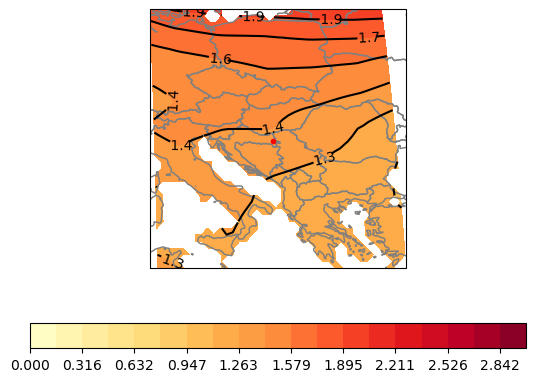

In [69]:
fig = plt.figure()

# Setup a global EckertIII map with faint coastlines.
ax = fig.add_subplot(1, 1, 1, projection=ccrs.EckertIII())
ax.set_global()
ax.coastlines('50m', alpha=0.1)

# Extract real data from your DataFrame
x, y, z = extract_data_from_df(difference_reset)

# Add colourful filled contours.
levels = np.linspace(0, 3, 20) # This creates 13 levels from -3 to +3

# Add colourful filled contours.
filled_c = ax.contourf(
    x, y, z, 
    levels=levels, 
    transform=ccrs.PlateCarree(), 
    cmap='YlOrRd'
)

#And black line contours.
line_c = ax.contour(x, y, z, levels=filled_c.levels,
                    colors=['black'],
                    transform=ccrs.PlateCarree())

lat_min, lat_max = difference_reset['lat'].min(), difference_reset['lat'].max()
lon_min, lon_max = difference_reset['lon'].min(), difference_reset['lon'].max()
ax.set_extent([lon_min, lon_max, lat_min, lat_max])


# Uncomment to make the line contours invisible.
# plt.setp(line_c.collections, visible=False)

# Add a colorbar for the filled contour.
fig.colorbar(filled_c, orientation='horizontal')

countries = cfeature.NaturalEarthFeature(
    category='cultural',
    name='admin_0_countries',
    scale='50m',
    edgecolor='black',
    facecolor='none')
ax.add_feature(countries, edgecolor='gray')
ax.plot(18.802666, 45.287865, 'ro', markersize=3, transform=ccrs.PlateCarree())


# Use the line contours to place contour labels.
ax.clabel(
    line_c,  # Typically best results when labelling line contours.
    colors=['black'],
    manual=False,  # Automatic placement vs manual placement.
    inline=True,  # Cut the line where the label will be placed.
    fmt=' {:.1f}'.format,  # Labes as integers, with some extra space.
)

plt.show()